# Parsing

In [38]:
!pip install requests
!pip install fake_useragent

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13489 sha256=82abccf77dfee4359e8c34bc4b485903817dc5ecfb12d8618362953d0dd24cba
  Stored in directory: c:\users\ksetd\appdata\local\pip\cache\wheels\a0\b8\b7\8c942b2c5be5158b874a88195116b05ad124bac795f6665e65
Successfully built fake-useragent


In [20]:
from bs4 import BeautifulSoup
import pandas as pd

In [8]:
import requests  

url = 'http://books.toscrape.com/catalogue/page-1.html'
response = requests.get(url)
response

<Response [200]>

In [3]:
import requests  

url = 'http://setdekov.xtreemhost.com/?i=1'
response = requests.get(url)
response

<Response [200]>

In [4]:
response.content[:1000]

b'<html><body><script type="text/javascript" src="/aes.js" ></script><script>function toNumbers(d){var e=[];d.replace(/(..)/g,function(d){e.push(parseInt(d,16))});return e}function toHex(){for(var d=[],d=1==arguments.length&&arguments[0].constructor==Array?arguments[0]:arguments,e="",f=0;f<d.length;f++)e+=(16>d[f]?"0":"")+d[f].toString(16);return e.toLowerCase()}var a=toNumbers("f655ba9d09a112d4968c63579db590b4"),b=toNumbers("98344c2eee86c3994890592585b49f80"),c=toNumbers("5efdbdb9f118904f4cd3db82113eb753");document.cookie="__test="+toHex(slowAES.decrypt(c,2,a,b))+"; expires=Thu, 31-Dec-37 23:55:55 GMT; path=/"; location.href="http://setdekov.xtreemhost.com/?i=2";</script><noscript>This site requires Javascript to work, please enable Javascript in your browser or use a browser with Javascript support</noscript></body></html>'

Внутри переменной `tree` теперь лежит дерево из тегов, по которому мы можем совершенно спокойно бродить. 

In [9]:
from bs4 import BeautifulSoup

# распарсили страничку в дерево 
tree = BeautifulSoup(response.content, 'html.parser')

In [10]:
tree.html.head.title

<title>
    All products | Books to Scrape - Sandbox
</title>

Можно вытащить из того места, куда мы забрели, текст с помощью метода `text`.

In [11]:
tree.html.head.title.text

'\n    All products | Books to Scrape - Sandbox\n'

С текстом можно работать классическими питоновскими методами. Например, можно избавиться от лишних отступов.

In [12]:
tree.html.head.title.text.strip()

'All products | Books to Scrape - Sandbox'

Более того, зная адрес элемента, мы сразу можем найти его. Например, вот так в коде страницы мы можем найти где именно для каждой книги лежит основная информация. Видно, что она находится внутри тега `article`, для которого прописан класс `product_pod` (грубо говоря, в html класс задаёт оформление соотвествующего кусочка страницы). 

<br> 
<img src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/gifs/find_element.gif" width="700"> 
<br> 

Вытащим инфу о книге из этого тега. 

In [14]:
books = tree.find_all('article', {'class' : 'product_pod'})
books[0]

<article class="product_pod">
<div class="image_container">
<a href="a-light-in-the-attic_1000/index.html"><img alt="A Light in the Attic" class="thumbnail" src="../media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/></a>
</div>
<p class="star-rating Three">
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
</p>
<h3><a href="a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
<div class="product_price">
<p class="price_color">£51.77</p>
<p class="instock availability">
<i class="icon-ok"></i>
    
        In stock
    
</p>
<form>
<button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>
</form>
</div>
</article>

In [15]:
books[0].find('p', {'class': 'price_color'}).text

'£51.77'

In [16]:
price = books[0].find('p', {'class': 'price_color'}).text

In [18]:
float(price[1:])

51.77

In [19]:
books[0].h3.a.get('href')

'a-light-in-the-attic_1000/index.html'

# pandas

In [21]:
def get_page(p):
    
    # изготовили ссылку
    url = 'http://books.toscrape.com/catalogue/page-{}.html'.format(p)
    
    # сходили по ней
    response = requests.get(url)
    
    # построили дерево 
    tree = BeautifulSoup(response.content, 'html.parser')
    
    # нашли в нём всё самое интересное
    books = tree.find_all('article', {'class' : 'product_pod'})
    
    infa = [ ]
    
    for book in books:
        infa.append({'price': book.find('p', {'class': 'price_color'}).text,
                     'href': book.h3.a.get('href'),
                     'title': book.h3.a.get('title')})
                     
    return infa

Осталось только пройтись по всем страничкам от page-1 до page-50 циклом и данные у нас в кармане. 

In [23]:
infa = []

for p in range(1,51):
    infa.extend(get_page(p))

In [24]:

df = pd.DataFrame(infa)
print(df.shape)
df.head()

(1000, 3)


,price,href,title
0,£51.77,a-light-in-the-attic_1000/index.html,A Light in the Attic
1,£53.74,tipping-the-velvet_999/index.html,Tipping the Velvet
2,£50.10,soumission_998/index.html,Soumission
3,£47.82,sharp-objects_997/index.html,Sharp Objects
4,£54.23,sapiens-a-brief-history-of-humankind_996/index...,Sapiens: A Brief History of Humankind


In [26]:
def get_price(price):
    return float(price[1:])

In [35]:
df['newprice'] = df['price'].apply(get_price)

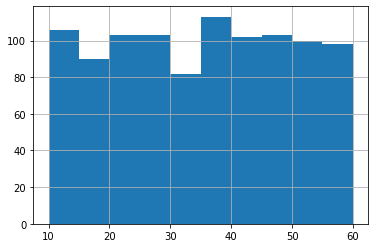

In [34]:
df['price'].apply(get_price).hist()

In [36]:
df.head()

,price,href,title,newprice
0,£51.77,a-light-in-the-attic_1000/index.html,A Light in the Attic,51.77
1,£53.74,tipping-the-velvet_999/index.html,Tipping the Velvet,53.74
2,£50.10,soumission_998/index.html,Soumission,50.10
3,£47.82,sharp-objects_997/index.html,Sharp Objects,47.82
4,£54.23,sapiens-a-brief-history-of-humankind_996/index...,Sapiens: A Brief History of Humankind,54.23


In [39]:
from fake_useragent import UserAgent
UserAgent().chrome

'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36'

Например, https://knowyourmeme.com/ не захочет пускать к себе python и выдаст ошибку 403. Она выдается сервером, если он доступен и способен обрабатывать запросы, но по некоторым личным причинам отказывается это делать.

In [40]:
url = 'https://knowyourmeme.com/'

response = requests.get(url)
response

<Response [403]>

А если сгенерировать User-Agent, вопросов у сервера не возникнет. 

In [41]:
response = requests.get(url, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [42]:
response.content[:400]

b'<!DOCTYPE html>\n<html xmlns:fb=\'https://www.facebook.com/2008/fbml\' xmlns=\'https://www.w3.org/1999/xhtml\'>\n<head>\n<meta content=\'text/html; charset=utf-8\' http-equiv=\'Content-Type\'>\n<script type="text/javascript">window.NREUM||(NREUM={});NREUM.info={"beacon":"bam-cell.nr-data.net","errorBeacon":"bam-cell.nr-data.net","licenseKey":"c1a6d52f38","applicationID":"31165848","transactionName":"dFdfRUpeW'

# контрольная на лекции - спарсить

## сайт http://quotes.toscrape.com/

* автор цитаты
* текст цитаты
* теги

In [44]:
    p =1 
    url = 'http://quotes.toscrape.com/page/{}/'.format(p)
    
    # сходили по ней
    response = requests.get(url)
    
    # построили дерево 
    tree = BeautifulSoup(response.content, 'html.parser')

In [45]:
tree

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Quotes to Scrape</title>
<link href="/static/bootstrap.min.css" rel="stylesheet"/>
<link href="/static/main.css" rel="stylesheet"/>
</head>
<body>
<div class="container">
<div class="row header-box">
<div class="col-md-8">
<h1>
<a href="/" style="text-decoration: none">Quotes to Scrape</a>
</h1>
</div>
<div class="col-md-4">
<p>
<a href="/login">Login</a>
</p>
</div>
</div>
<div class="row">
<div class="col-md-8">
<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="

In [68]:
quotes = tree.find_all('div', {'class':'quote'})

In [69]:
quotes[0]

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>

In [ ]:
        infa.append({'price': book.find('p', {'class': 'price_color'}).text,
                     'href': book.h3.a.get('href'),
                     'title': book.h3.a.get('title')})

In [85]:
quotes[0].find('small', {'class':'author'}).text

'Albert Einstein'

In [86]:
quotes[0].find('span', {'class':'text'}).text

'“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”'

In [112]:
alltags = quotes[0].find('div', {'class':'tags'}).find_all('a', {'class':'tag'})

In [113]:
alltags

[<a class="tag" href="/tag/change/page/1/">change</a>,
 <a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>,
 <a class="tag" href="/tag/thinking/page/1/">thinking</a>,
 <a class="tag" href="/tag/world/page/1/">world</a>]

In [111]:
import re
for i in alltags:
    i_text = i.text
    print(i_text)


change
deep-thoughts
thinking
world


In [103]:
type(alltags[0])

bs4.element.Tag

In [ ]:
re.findall()

In [71]:
infa = [ ]
    
for one_quote in quotes:
    print(one_quote)

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>
<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“It is our choices, Harry, that show what we truly are, far more than our abilities.”</span>
<span>by <small class="author" itemprop="author">J.K. R

In [66]:
quotes[0]

<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>